## Imports

In [18]:
from autograd import Value, populate_dataframe, build_causal_graph, draw_computational_graph
import numpy as np
import pandas as pd
from shapflow.flow import GraphExplainer, CausalLinks, build_feature_graph
import os
import random
import inspect
from scipy.stats.mstats import zscore

## Constants

In [19]:
TEMPERATURE = 323
ADSORBATE = 'CH4'
TARGET_ADSORBENT = 'SIV'
CATALYSTS_LOC_STR = "data/zeolite/complete_data_avail.xlsx"
_CATALYSTS_DATA = pd.read_excel(CATALYSTS_LOC_STR)
ADSORBATE_LOC_STR = f"data/zeolite/{ADSORBATE}.xlsx"
ADSORBATE_DATA: dict = pd.read_excel(ADSORBATE_LOC_STR, sheet_name=None)
RESULTS_FILE_PATH = f'data/zeolite/{ADSORBATE}_RESULTS_{str(TEMPERATURE)}.npy'

In [20]:
with open(RESULTS_FILE_PATH, 'rb') as RESULTS_FILE:
    X_train = np.load(RESULTS_FILE, allow_pickle=True)
    X_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred = np.load(RESULTS_FILE, allow_pickle=True)
    y_train = np.load(RESULTS_FILE, allow_pickle=True)
    y_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_train = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_test = np.load(RESULTS_FILE, allow_pickle=True)
    P_TRAIN_STD = np.load(RESULTS_FILE, allow_pickle=True)

In [21]:
P_TRAIN_STD

array(1840178.90356372)

## Equation

In [22]:
def ch4_323_function(
        P, density, spg, volume, SiOSi_average, SiOSi_gmean, SiOSi_hmean, SiOSi_max, SiOSi_mean, SiOSi_min,
        SiOSi_skew, SiOSi_std, SiOSi_var, SiO_average, SiO_gmean, SiO_hmean, SiO_max, SiO_mean, SiO_min,
        SiO_skew, SiO_std, SiO_var, ASA, AV, NASA, NAV, VolFrac, largest_free_sphere, largest_included_sphere,
        largest_included_sphere_free, max_dim, min_dim, mode_dim, pld, lcd, void_frac, surf_area_m2g, surf_area_m2cm3
    ):
    # TODO: Make sure that pressure is normalized correctly
    # TODO: check the equations line by line
    Value.reset()

    # input variables
    P = Value(P, label='P')
    density = Value(density, label='density')
    spg = Value(spg, label='spg')
    volume = Value(volume, label='volume')
    SiOSi_average = Value(SiOSi_average, label='SiOSi_average')
    SiOSi_gmean = Value(SiOSi_gmean, label='SiOSi_gmean')
    SiOSi_hmean = Value(SiOSi_hmean, label='SiOSi_hmean')
    SiOSi_max = Value(SiOSi_max, label='SiOSi_max')
    SiOSi_mean = Value(SiOSi_mean, label='SiOSi_mean')
    SiOSi_min = Value(SiOSi_min, label='SiOSi_min')
    SiOSi_skew = Value(SiOSi_skew, label='SiOSi_skew')
    SiOSi_std = Value(SiOSi_std, label='SiOSi_std')
    SiOSi_var = Value(SiOSi_var, label='SiOSi_var')
    SiO_average = Value(SiO_average, label='SiO_average')
    SiO_gmean = Value(SiO_gmean, label='SiO_gmean')
    SiO_hmean = Value(SiO_hmean, label='SiO_hmean')
    SiO_max = Value(SiO_max, label='SiO_max')
    SiO_mean = Value(SiO_mean, label='SiO_mean')
    SiO_min = Value(SiO_min, label='SiO_min')
    SiO_skew = Value(SiO_skew, label='SiO_skew')
    SiO_std = Value(SiO_std, label='SiO_std')
    SiO_var = Value(SiO_var, label='SiO_var')
    ASA = Value(ASA, label='ASA')
    AV = Value(AV, label='AV')
    NASA = Value(NASA, label='NASA')
    NAV = Value(NAV, label='NAV')
    VolFrac = Value(VolFrac, label='VolFrac')
    largest_free_sphere = Value(largest_free_sphere, label='largest_free_sphere')
    largest_included_sphere = Value(largest_included_sphere, label='largest_included_sphere')
    largest_included_sphere_free = Value(largest_included_sphere_free, label='largest_included_sphere_free')
    max_dim = Value(max_dim, label='max_dim')
    min_dim = Value(min_dim, label='min_dim')
    mode_dim = Value(mode_dim, label='mode_dim')
    pld = Value(pld, label='pld')
    lcd = Value(lcd, label='lcd')
    void_frac = Value(void_frac, label='void_frac')
    surf_area_m2g = Value(surf_area_m2g, label='surf_area_m2g')
    surf_area_m2cm3 = Value(surf_area_m2cm3, label='surf_area_m2cm3')

    # constants
    beta1 = Value(-0.4054507842872319, label='beta1')
    beta2 = Value(-3.5824569383000946, label='beta2')
    beta3 = Value(3.9932667095050705, label='beta3')
    beta4 = Value(0.5222507180877926, label='beta4')
    beta5 = Value(0.004795464592376811, label='beta5')
    beta6 = Value(-0.1129628499436825, label='beta6')
    beta7 = Value(0.013835556053187287, label='beta7')
    beta8 = Value(-0.09608874134668977, label='beta8')
    intercept = Value(0.0, label='intercept')

    # f terms
    f1 = ((largest_included_sphere*NAV.exp()*(-surf_area_m2cm3).exp()) * P / 
        (1 + (largest_included_sphere*NAV.exp()*(-surf_area_m2cm3).exp()) * P) - 
        0.07469040214406462)/0.23351307544167757
    f1.label = 'f1'

    f2 = ((VolFrac.exp()/(-AV).exp()) * P / 
        (1 + (VolFrac.exp()/(-AV).exp()) * P) - 
        0.593439038924528)/0.19855903035643785
    f2.label = 'f2'

    f3 = ((void_frac.exp()) * P / 
        (1 + (void_frac.exp()) * P) - 
        0.6258918477237851)/0.19909573031440259
    f3.label = 'f3'

    f4 = ((AV/VolFrac.exp()*void_frac) * P / 
        (1 + (AV/VolFrac.exp()*void_frac) * P) - 
        0.026347531768028034)/0.033050115887121194
    f4.label = 'f4'

    f5 = (((-NASA).exp()*(surf_area_m2cm3**2)*spg) * P / 
        (1 + ((-NASA).exp()*(surf_area_m2cm3**2)*spg) * P) - 
        0.451590663829706)/0.4976497103725683
    f5.label = 'f5'

    f6 = (((surf_area_m2cm3**2)*(-volume).exp()*volume) * P / 
        (1 + ((surf_area_m2cm3**2)*(-volume).exp()*volume) * P) - 
        0.04040880811128878)/0.05992104058313283
    f6.label = 'f6'

    f7 = ((1/surf_area_m2g.exp()/pld) * P / 
        (1 + (1/surf_area_m2g.exp()/pld) * P) - 
        0.033471221601783376)/0.11285951143033723
    f7.label = 'f7'

    f8 = ((VolFrac**2/(-pld).exp()) * P / 
        (1 + (VolFrac**2/(-pld).exp()) * P) - 
        0.3805783317820693)/0.36837799819503636
    f8.label = 'f8'

    theta = beta1*f1 + beta2*f2 + beta3*f3 + beta4*f4 + beta5*f5 + beta6*f6 + beta7*f7 + beta8*f8

    loading_at_zero_P = (
        -beta1*0.07469040214406462/0.233513075441677571 +
        -beta2*0.593439038924528/0.198559030356437852 + 
        -beta3*0.6258918477237851/0.199095730314402593 + 
        -beta4*0.026347531768028034/0.0330501158871211944 + 
        -beta5*0.451590663829706/0.49764971037256835 + 
        -beta6*0.04040880811128878/0.059921040583132836 + 
        -beta7*0.033471221601783376/0.112859511430337237 + 
        -beta8*0.3805783317820693/0.368377998195036368
    )

    epsilon_max = 1.0
    d = (P - 0.0).abs()
    alpha = 2.0
    y_train_mean = np.mean(y_train)

    y = theta + intercept + y_train_mean + (loading_at_zero_P + y_train_mean).abs() * epsilon_max * (-alpha * d).exp()
    y.label = 'y'

    return y

## Generate and Prepare Data

In [23]:
# co2_file_path = 'data/co2/CO2.xlsx'
# # Load co2 data as a dict where the keys are the catalyst name and the values are the respective dataframes
# co2: dict = pd.read_excel(co2_file_path, sheet_name=None)
# P_TRAIN_STD = 1839573.4508480425 # Taken from Arijit's Jupyter Notebook where he runs AI DARWIN algo to get the final equation

catalyst_names = []
for catalyst_name, df in ADSORBATE_DATA.items():
    catalyst_names.append(catalyst_name)
    # Rename columns to our variable names
    df.rename(columns={'Temperature (K)': 'temperature', 'Pressure (Pa)' : 'P'}, inplace=True)

    # Divide pressure term by P_TRAIN_STD to follow Arijit's methodology to generate the AI DARWIN equation
    df['P'] = df['P'] / P_TRAIN_STD

    # Split each sheet into temperature buckets
    df_grouped_by_temperature = df.groupby('temperature')
    ADSORBATE_DATA[catalyst_name] = {temperature: df_group for temperature, df_group in df_grouped_by_temperature}

ADSORBATE_DATA['SBS'][323]

,temperature,P,Absolute Loading (mol/kg)
11,323,0.000706,0.001959
12,323,0.002880,0.008037
13,323,0.005815,0.016065
14,323,0.011575,0.031874
15,323,0.023204,0.063876
16,323,0.046354,0.123611
17,323,0.055049,0.145687
18,323,0.144877,0.378134
19,323,0.315187,0.783219
20,323,1.901989,2.874703


In [24]:
# Remove every row that contains a nan
CATALYSTS_DATA = _CATALYSTS_DATA.dropna(inplace=False)

# Drop unnamed columns
CATALYSTS_DATA = CATALYSTS_DATA.loc[:, ~CATALYSTS_DATA.columns.str.contains('^Unnamed')]

# Separate numeric columns from str columns to perform numeric operations
catalyst_names = CATALYSTS_DATA['name'] 
numeric_cols = CATALYSTS_DATA.select_dtypes(include=[np.number]).columns
CATALYSTS_DATA = CATALYSTS_DATA[numeric_cols]

# Z-score each numeric column
CATALYSTS_DATA = CATALYSTS_DATA.apply(zscore)

# Insert catalyst names back numeric columns
CATALYSTS_DATA.insert(loc=0, column='name', value=catalyst_names)

# Convert catalysts into a dictionary with catalyst name as the key and the values are the properties of the catalyst in dict format
CATALYSTS_DATA = CATALYSTS_DATA.set_index('name').to_dict(orient='index')
CATALYSTS_DATA['SBS']

{'density': -1.8558630932892477,
 'spg': 1.2624683088634494,
 'volume': 1.793626923931012,
 'SiOSi_average': -0.8863144687132899,
 'SiOSi_gmean': -0.8619418348316873,
 'SiOSi_hmean': -0.8373436573306983,
 'SiOSi_max': -1.3822614723202076,
 'SiOSi_mean': -0.8863144687132899,
 'SiOSi_min': -0.4294011773596648,
 'SiOSi_skew': -0.8391314491267721,
 'SiOSi_std': -1.030422199053148,
 'SiOSi_var': -0.8597443678263218,
 'SiO_average': 0.09841020073221819,
 'SiO_gmean': 0.11525976617628211,
 'SiO_hmean': 0.12315403662807878,
 'SiO_max': 0.3361714402447173,
 'SiO_mean': 0.09841020073221819,
 'SiO_min': 0.12009515640585561,
 'SiO_skew': 1.040308818872039,
 'SiO_std': -0.10976626252065085,
 'SiO_var': -0.11601125779625783,
 'ASA': 1.90937178129791,
 'AV': 2.127520986920949,
 'NASA': -0.6807185333684872,
 'NAV': -0.3361041141839826,
 'VolFrac': 2.239583324075746,
 'largest_free_sphere': 1.5469201241674324,
 'largest_included_sphere': 2.174034646928647,
 'largest_included_sphere_free': 2.24045140315

In [25]:
missing_catalysts = set()
# Add catalyst properties to each adsorbate sheet
for catalyst_name, adsorbate_grouped_by_temperature in ADSORBATE_DATA.items():
    for temperature, df in adsorbate_grouped_by_temperature.items():
        try:
            for catalyst_property in CATALYSTS_DATA[catalyst_name]:
                ADSORBATE_DATA[catalyst_name][temperature][catalyst_property] = CATALYSTS_DATA[catalyst_name][catalyst_property]
        except KeyError: # Case where we are missing data on a given catalyst
            missing_catalysts.add(catalyst_name)

# For now, delete all co2 sheets that use a catalyst with missing data:
for catalyst_name in missing_catalysts:
    del ADSORBATE_DATA[catalyst_name]

print("Missing catalysts:", list(missing_catalysts))
ADSORBATE_DATA['SBS'][323]

Missing catalysts: ['CHA', 'JSN', 'BEA', 'SFV', 'AFI', 'RUT', 'FAU', 'MAR', 'STO', 'OSO', 'MRE', 'CAN']


,temperature,P,Absolute Loading (mol/kg),density,spg,volume,SiOSi_average,SiOSi_gmean,SiOSi_hmean,SiOSi_max,...,largest_included_sphere,largest_included_sphere_free,max_dim,min_dim,mode_dim,pld,lcd,void_frac,surf_area_m2g,surf_area_m2cm3
11,323,0.000706,0.001959,-1.855863,1.262468,1.793627,-0.886314,-0.861942,-0.837344,-1.382261,...,2.174035,2.240451,1.191537,1.234825,1.234825,1.530717,2.167132,1.788517,1.901897,1.864466
12,323,0.002880,0.008037,-1.855863,1.262468,1.793627,-0.886314,-0.861942,-0.837344,-1.382261,...,2.174035,2.240451,1.191537,1.234825,1.234825,1.530717,2.167132,1.788517,1.901897,1.864466
13,323,0.005815,0.016065,-1.855863,1.262468,1.793627,-0.886314,-0.861942,-0.837344,-1.382261,...,2.174035,2.240451,1.191537,1.234825,1.234825,1.530717,2.167132,1.788517,1.901897,1.864466
14,323,0.011575,0.031874,-1.855863,1.262468,1.793627,-0.886314,-0.861942,-0.837344,-1.382261,...,2.174035,2.240451,1.191537,1.234825,1.234825,1.530717,2.167132,1.788517,1.901897,1.864466
15,323,0.023204,0.063876,-1.855863,1.262468,1.793627,-0.886314,-0.861942,-0.837344,-1.382261,...,2.174035,2.240451,1.191537,1.234825,1.234825,1.530717,2.167132,1.788517,1.901897,1.864466
16,323,0.046354,0.123611,-1.855863,1.262468,1.793627,-0.886314,-0.861942,-0.837344,-1.382261,...,2.174035,2.240451,1.191537,1.234825,1.234825,1.530717,2.167132,1.788517,1.901897,1.864466
17,323,0.055049,0.145687,-1.855863,1.262468,1.793627,-0.886314,-0.861942,-0.837344,-1.382261,...,2.174035,2.240451,1.191537,1.234825,1.234825,1.530717,2.167132,1.788517,1.901897,1.864466
18,323,0.144877,0.378134,-1.855863,1.262468,1.793627,-0.886314,-0.861942,-0.837344,-1.382261,...,2.174035,2.240451,1.191537,1.234825,1.234825,1.530717,2.167132,1.788517,1.901897,1.864466
19,323,0.315187,0.783219,-1.855863,1.262468,1.793627,-0.886314,-0.861942,-0.837344,-1.382261,...,2.174035,2.240451,1.191537,1.234825,1.234825,1.530717,2.167132,1.788517,1.901897,1.864466
20,323,1.901989,2.874703,-1.855863,1.262468,1.793627,-0.886314,-0.861942,-0.837344,-1.382261,...,2.174035,2.240451,1.191537,1.234825,1.234825,1.530717,2.167132,1.788517,1.901897,1.864466


In [ ]:
# TODO: Create a function map for each function at each adsorbate and temperature

# Populate every co2 eq for each catalyst at every temperature
for catalyst_name, adsorbate_grouped_by_temperature in ADSORBATE_DATA.items():
    for temperature, df in adsorbate_grouped_by_temperature.items():
        if temperature == 323:
            populate_dataframe(df, ch4_323_function)
        elif temperature == 373:
            pass
            # populate_dataframe(df, co2_373_function)

In [58]:
X = ADSORBATE_DATA['SIV'][TEMPERATURE]
X

,temperature,P,Absolute Loading (mol/kg),density,spg,volume,SiOSi_average,SiOSi_gmean,SiOSi_hmean,SiOSi_max,...,0.033471221601783376,(0.033471221601783376*(-beta7)),(8.860573533647202*(0.033471221601783376*(-beta7))),(((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7)))),((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8)))),(((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8))))+1.8012967520175298),|(((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8))))+1.8012967520175298)|,(1.0*|(((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8))))+1.8012967520175298)|),(e^((-2.0*|(P-0.0)|))*(1.0*|(((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8))))+1.8012967520175298)|)),y
11,323,0.000706,0.003045,-0.310126,-0.397474,0.171504,-0.153204,-0.114799,-0.07647,-1.336843,...,0.033471,-0.000463,-0.004103,-2.065462,-1.966191,-0.164894,0.164894,0.164894,0.164661,0.009384
12,323,0.002880,0.012484,-0.310126,-0.397474,0.171504,-0.153204,-0.114799,-0.07647,-1.336843,...,0.033471,-0.000463,-0.004103,-2.065462,-1.966191,-0.164894,0.164894,0.164894,0.163947,0.038139
13,323,0.005815,0.025254,-0.310126,-0.397474,0.171504,-0.153204,-0.114799,-0.07647,-1.336843,...,0.033471,-0.000463,-0.004103,-2.065462,-1.966191,-0.164894,0.164894,0.164894,0.162987,0.076674
14,323,0.011575,0.049759,-0.310126,-0.397474,0.171504,-0.153204,-0.114799,-0.07647,-1.336843,...,0.033471,-0.000463,-0.004103,-2.065462,-1.966191,-0.164894,0.164894,0.164894,0.161120,0.151378
15,323,0.023204,0.098997,-0.310126,-0.397474,0.171504,-0.153204,-0.114799,-0.07647,-1.336843,...,0.033471,-0.000463,-0.004103,-2.065462,-1.966191,-0.164894,0.164894,0.164894,0.157416,0.298467
16,323,0.046354,0.189515,-0.310126,-0.397474,0.171504,-0.153204,-0.114799,-0.07647,-1.336843,...,0.033471,-0.000463,-0.004103,-2.065462,-1.966191,-0.164894,0.164894,0.164894,0.150294,0.576838
17,323,0.055049,0.221952,-0.310126,-

<Axes: xlabel='P'>

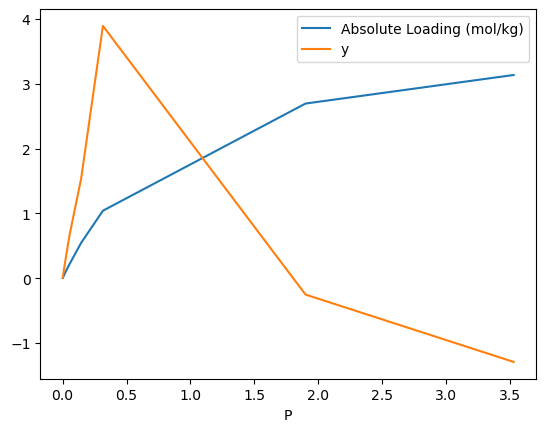

In [59]:
# Plot the P on the x-axis and Absolute Loading (mol/kg) and y on the y-axis
X.plot(x='P', y=['Absolute Loading (mol/kg)', 'y'], kind='line')

## Generate Computational Graph

Computational Graph Generated


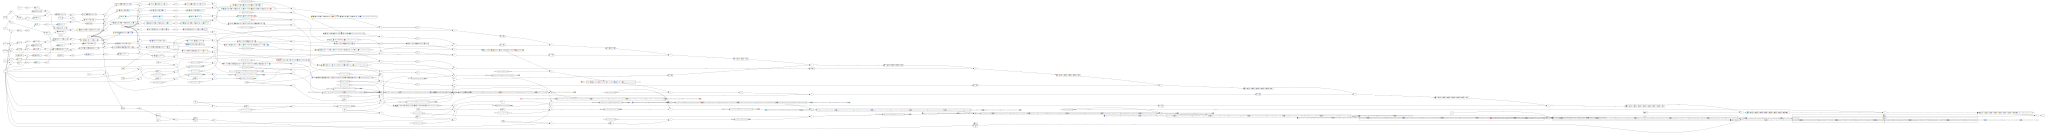

In [60]:
Value.reset()
# Pass in arbitrary values into our function because we are just trying to construct the causal graph
y = ch4_323_function(*([0.1] * len(inspect.signature(ch4_323_function).parameters)))
target_name = 'y'

computational_graph = draw_computational_graph(y, disable_data_field=True, disable_grad_field=True)
print("Computational Graph Generated")
computational_graph

## Build Causal Graph

[(['(0.026347531768028034*(-beta4))', '30.257079987718743'], ['(30.257079987718743*(0.026347531768028034*(-beta4)))'], [<function op_to_function.<locals>.mul at 0x31ea68cc0>]), (['(-volume)'], ['e^((-volume))'], [<function op_to_function.<locals>.exp at 0x31ea69ee0>]), (['(((P*(volume*(e^((-volume))*(surf_area_m2cm3**2))))+1)**-1)', '(P*(volume*(e^((-volume))*(surf_area_m2cm3**2))))'], ['((((P*(volume*(e^((-volume))*(surf_area_m2cm3**2))))+1)**-1)*(P*(volume*(e^((-volume))*(surf_area_m2cm3**2)))))'], [<function op_to_function.<locals>.mul at 0x31ea696c0>]), (['(P*(e^((-surf_area_m2cm3))*(e^(NAV)*largest_included_sphere)))', '1'], ['((P*(e^((-surf_area_m2cm3))*(e^(NAV)*largest_included_sphere)))+1)'], [<function op_to_function.<locals>.add at 0x31f7b1f80>]), (['-1', 'pld'], ['(-pld)'], [<function op_to_function.<locals>.mul at 0x31e7da0c0>]), (['(((((f1*beta1)+(f2*beta2))+(f3*beta3))+(f4*beta4))+(f5*beta5))', '(f6*beta6)'], ['((((((f1*beta1)+(f2*beta2))+(f3*beta3))+(f4*beta4))+(f5*beta5

0it [00:00, ?it/s]


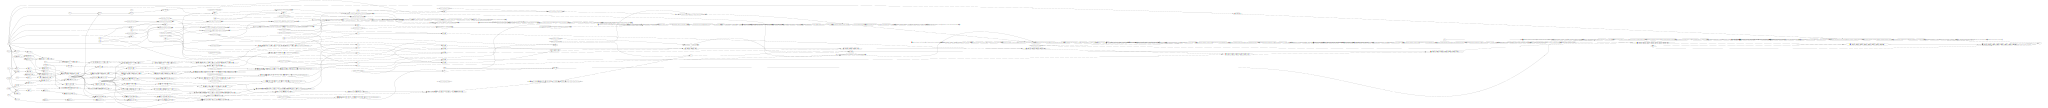

In [61]:
X = X.drop(labels=['y'], axis=1)

causal_graph = build_causal_graph(y, X, target_name, debug=False)
causal_graph.draw(rankdir='LR')

## Shapley Flow Analysis

### Holding Pressure Constant

In [64]:
nruns = 100 # number of monte carlo samples
sample_ind = 0
background_catalyst = 'JRY'
bg = ADSORBATE_DATA[background_catalyst][TEMPERATURE].sample(1).drop(labels=['y'], axis=1) # background sample, no need for multiple sample because of the linearity axiom
bg_pressure_value = bg['P'].iloc[0]
fg = X[X['P'] == bg_pressure_value] # foreground samples to explain. Selecting row from X such that the pressure value is equal to the pressure value of bg
bg = bg[fg.columns] # ensure fg and bg have same column order. NOTE: this only works when there is 1 fg

In [65]:
print(background_catalyst)
bg

JRY


,temperature,P,Absolute Loading (mol/kg),density,spg,volume,SiOSi_average,SiOSi_gmean,SiOSi_hmean,SiOSi_max,...,(-beta7),0.033471221601783376,(0.033471221601783376*(-beta7)),(8.860573533647202*(0.033471221601783376*(-beta7))),(((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7)))),((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8)))),(((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8))))+1.8012967520175298),|(((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8))))+1.8012967520175298)|,(1.0*|(((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8))))+1.8012967520175298)|),(e^((-2.0*|(P-0.0)|))*(1.0*|(((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8))))+1.8012967520175298)|))
21,323,3.532265,2.446487,0.92237,-0.970374,-0.789028,0.276405,0.265038,0.254601,0.62623,...,-0.013836,0.033471,-0.000463,-0.004103,-2.065462,-1.966191,-0.164894,0.164894,0.164894,0.000141


In [66]:
fg

,temperature,P,Absolute Loading (mol/kg),density,spg,volume,SiOSi_average,SiOSi_gmean,SiOSi_hmean,SiOSi_max,...,(-beta7),0.033471221601783376,(0.033471221601783376*(-beta7)),(8.860573533647202*(0.033471221601783376*(-beta7))),(((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7)))),((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8)))),(((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8))))+1.8012967520175298),|(((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8))))+1.8012967520175298)|,(1.0*|(((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8))))+1.8012967520175298)|),(e^((-2.0*|(P-0.0)|))*(1.0*|(((((((((4.282415441227662*(0.07469040214406462*(-beta1)))+(5.036285673861708*(0.593439038924528*(-beta2))))+(5.022709419337357*(0.6258918477237851*(-beta3))))+(30.257079987718743*(0.026347531768028034*(-beta4))))+(2.009445558104202*(0.451590663829706*(-beta5))))+(16.688628739893577*(0.04040880811128878*(-beta6))))+(8.860573533647202*(0.033471221601783376*(-beta7))))+(2.714602948329595*(0.3805783317820693*(-beta8))))+1.8012967520175298)|))
21,323,3.532265,3.135007,-0.310126,-0.397474,0.171504,-0.153204,-0.114799,-0.07647,-1.336843,...,-0.013836,0.033471,-0.000463,-0.004103,-2.065462,-1.966191,-0.164894,0.164894,0.164894,0.000141


bruteforce sampling: 100%|██████████| 100/100 [00:01<00:00, 78.24it/s]


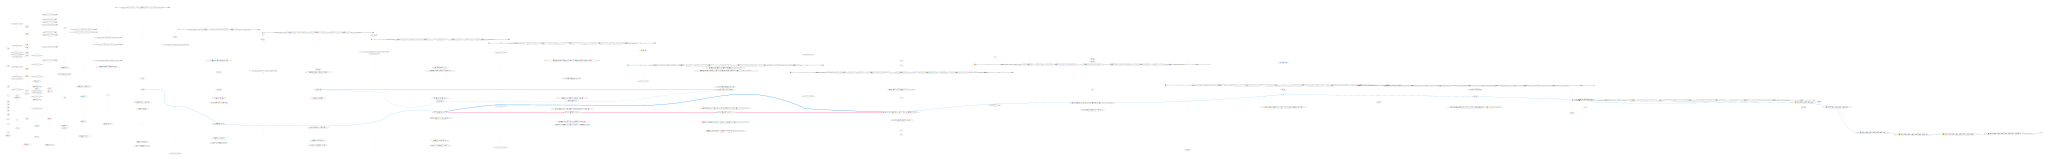

In [67]:
cf_flow = GraphExplainer(causal_graph, bg, nruns=nruns).shap_values(fg, rankdir='LR')
cf_flow.fold_noise = True
shapflow_graph_with_constant_pressure = cf_flow.draw(sample_ind, show_fg_val=False)#, rankdir='TB')

### Holding Catalyst Constant

In [23]:
nruns = 100 # number of monte carlo samples
sample_ind = 0
samples = X.sample(2)
bg = samples.iloc[0:1]
fg = samples.iloc[1:]

In [24]:
bg

,temperature,P,Absolute Loading (mol/kg),density,spg,volume,SiOSi_average,SiOSi_gmean,SiOSi_hmean,SiOSi_max,...,e^((-ASA)),(e^(surf_area_m2g)**-1),((e^(surf_area_m2g)**-1)*e^((-ASA))),f14,(P*f14),((P*f14)+1),(((P*f14)+1)**-1),((((P*f14)+1)**-1)*(P*f14)),(((((P*f14)+1)**-1)*(P*f14))*beta14),((((((((((((((((((P*f1)+1)**-1)*(P*f1))*beta1)+(((((P*f2)+1)**-1)*(P*f2))*beta2))+(((((P*f3)+1)**-1)*(P*f3))*beta3))+(((((P*f4)+1)**-1)*(P*f4))*beta4))+(((((P*f5)+1)**-1)*(P*f5))*beta5))+(((((P*f6)+1)**-1)*(P*f6))*beta6))+(((((P*f7)+1)**-1)*(P*f7))*beta7))+(((((P*f8)+1)**-1)*(P*f8))*beta8))+(((((P*f9)+1)**-1)*(P*f9))*beta9))+(((((P*f10)+1)**-1)*(P*f10))*beta10))+(((((P*f11)+1)**-1)*(P*f11))*beta11))+(((((P*f12)+1)**-1)*(P*f12))*beta12))+(((((P*f13)+1)**-1)*(P*f13))*beta13))+(((((P*f14)+1)**-1)*(P*f14))*beta14))
27,373,0.046369,0.171927,0.320074,-0.676579,-0.348657,0.540045,0.565635,0.590252,-0.287646,...,0.7734,1.051058,0.812888,-39.70081,-1.840905,-0.840905,-1.189196,2.189196,-0.000127,0.441212


In [25]:
fg

,temperature,P,Absolute Loading (mol/kg),density,spg,volume,SiOSi_average,SiOSi_gmean,SiOSi_hmean,SiOSi_max,...,e^((-ASA)),(e^(surf_area_m2g)**-1),((e^(surf_area_m2g)**-1)*e^((-ASA))),f14,(P*f14),((P*f14)+1),(((P*f14)+1)**-1),((((P*f14)+1)**-1)*(P*f14)),(((((P*f14)+1)**-1)*(P*f14))*beta14),((((((((((((((((((P*f1)+1)**-1)*(P*f1))*beta1)+(((((P*f2)+1)**-1)*(P*f2))*beta2))+(((((P*f3)+1)**-1)*(P*f3))*beta3))+(((((P*f4)+1)**-1)*(P*f4))*beta4))+(((((P*f5)+1)**-1)*(P*f5))*beta5))+(((((P*f6)+1)**-1)*(P*f6))*beta6))+(((((P*f7)+1)**-1)*(P*f7))*beta7))+(((((P*f8)+1)**-1)*(P*f8))*beta8))+(((((P*f9)+1)**-1)*(P*f9))*beta9))+(((((P*f10)+1)**-1)*(P*f10))*beta10))+(((((P*f11)+1)**-1)*(P*f11))*beta11))+(((((P*f12)+1)**-1)*(P*f12))*beta12))+(((((P*f13)+1)**-1)*(P*f13))*beta13))+(((((P*f14)+1)**-1)*(P*f14))*beta14))
28,373,0.055067,0.204187,0.320074,-0.676579,-0.348657,0.540045,0.565635,0.590252,-0.287646,...,0.7734,1.051058,0.812888,-39.70081,-2.186209,-1.186209,-0.843022,1.843022,-0.000107,0.471917


bruteforce sampling: 100%|██████████| 100/100 [00:01<00:00, 76.24it/s]


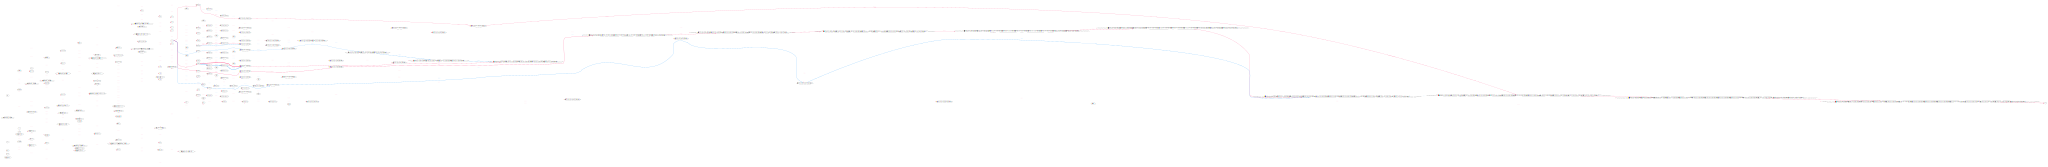

In [26]:
cf_flow = GraphExplainer(causal_graph, bg, nruns=nruns).shap_values(fg, rankdir='LR')
cf_flow.fold_noise = True
shapflow_graph_with_constant_catalyst = cf_flow.draw(sample_ind, show_fg_val=False)#, rankdir='TB')

### Simplified Shapley Flow With f Terms Only

In [27]:
def langmuir_transformation(f, P):
    return (f*P)/(1 + f*P)

0it [00:00, ?it/s]


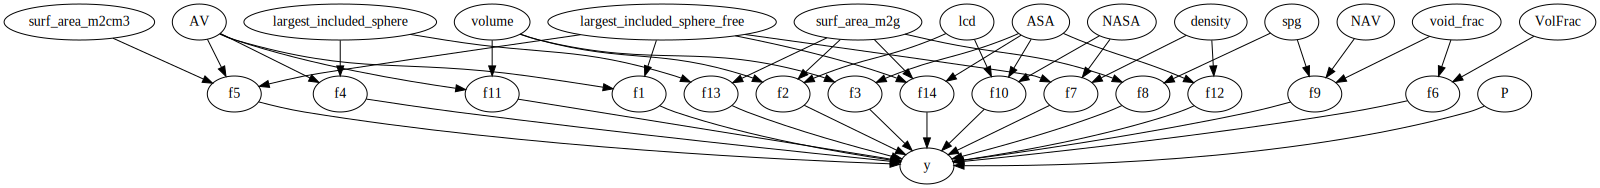

random_catalyst='JSW'


bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 327.30it/s]


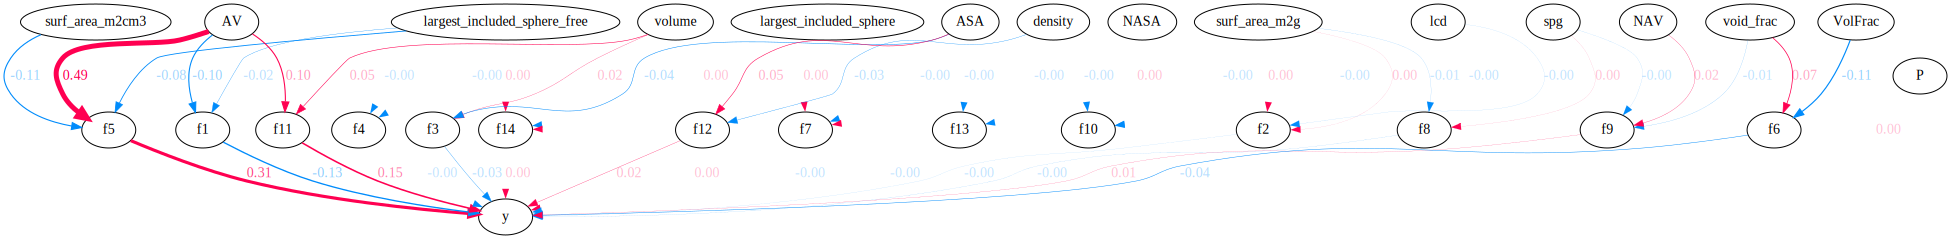

In [28]:
# constants
beta1  = -0.3594413972218853
beta2  = 0.7236283377256563
beta3  = -2.491688880718375
beta4  = 0.09275076505414136
beta5  = 0.9655176044485131
beta6  = 6.602116824421418
beta7  = -8.506535242975505e-06
beta8  = -1.613293940314934
beta9  = 1.275887158343305
beta10 = -4.973935475022366e-06
beta11 = -3.3528986757269825
beta12 = 2.5511241106011875
beta13 = 0.00015360330426490517
beta14 = -5.8135254289460757e-05
constants = [beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14]

causal_links = CausalLinks()
target_name = 'y'
X_with_only_f_terms = X[['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14']]
causal_links.add_causes_effects(
    ['P', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14'],
    target_name,
    lambda P, *features: sum([beta * langmuir_transformation(f, P) for (beta, f) in zip(constants, features)]),
)

causal_links.add_causes_effects(['AV', 'largest_included_sphere_free'], ['f1'], lambda AV, largest_included_sphere_free: 1/((AV)**2)*np.exp(largest_included_sphere_free))
causal_links.add_causes_effects(['lcd', 'surf_area_m2g', 'volume'], ['f2'], lambda lcd, surf_area_m2g, volume : ((lcd)**2)/np.exp(-surf_area_m2g)/np.exp(-volume))
causal_links.add_causes_effects(['ASA', 'volume'], ['f3'], lambda ASA, volume : np.exp(ASA)/np.exp(volume))
causal_links.add_causes_effects(['AV', 'largest_included_sphere'], ['f4'], lambda AV, largest_included_sphere : ((AV)**3)*((largest_included_sphere)**3))
causal_links.add_causes_effects(['largest_included_sphere_free', 'AV', 'surf_area_m2cm3'], ['f5'], lambda largest_included_sphere_free, AV, surf_area_m2cm3 : np.exp(-largest_included_sphere_free)/((AV)**2)/np.exp(surf_area_m2cm3))
causal_links.add_causes_effects(['VolFrac', 'void_frac'], ['f6'], lambda VolFrac, void_frac : 1/np.exp(VolFrac)*np.exp(void_frac))
causal_links.add_causes_effects(['density', 'largest_included_sphere_free', 'NASA'], ['f7'], lambda density, largest_included_sphere_free, NASA : (density)/np.exp(-largest_included_sphere_free)*((NASA)**3))
causal_links.add_causes_effects(['spg', 'surf_area_m2g'], ['f8'], lambda spg, surf_area_m2g : np.exp(spg)*np.exp(surf_area_m2g))
causal_links.add_causes_effects(['spg', 'NAV', 'void_frac'], ['f9'], lambda spg, NAV, void_frac : np.exp(spg)/np.exp(NAV)/np.exp(void_frac))
causal_links.add_causes_effects(['NASA', 'ASA', 'lcd'], ['f10'], lambda NASA, ASA, lcd : (NASA)*((ASA)**3)/np.exp(lcd))
causal_links.add_causes_effects(['volume', 'AV'], ['f11'], lambda volume, AV : 1/np.exp(volume)/np.exp(AV))
causal_links.add_causes_effects(['density', 'ASA'], ['f12'], lambda density, ASA : np.exp(density)*np.exp(ASA))
causal_links.add_causes_effects(['largest_included_sphere', 'surf_area_m2g'], ['f13'], lambda largest_included_sphere, surf_area_m2g : np.exp(largest_included_sphere)/(surf_area_m2g)*np.exp(-surf_area_m2g))
causal_links.add_causes_effects(['ASA', 'surf_area_m2g', 'largest_included_sphere_free'], ['f14'], lambda ASA, surf_area_m2g, largest_included_sphere_free : np.exp(-ASA)/np.exp(surf_area_m2g)/(largest_included_sphere_free))

causal_graph_simplified = build_feature_graph(X_with_only_f_terms, causal_links, target_name=target_name)
causal_graph_simplified.draw(rankdir='TB')

nruns = 100 # number of monte carlo samples
sample_ind = 0
random_catalyst = random.choice(list(co2.keys())) # Sample a random catalyst
print(f'{random_catalyst=}')

bg = co2[random_catalyst][373].sample(1).drop(labels=['y'], axis=1) # background sample, no need for multiple sample because of the linearity axiom
bg_pressure_value = bg['P'].iloc[0]
fg = X_with_only_f_terms[X_with_only_f_terms['P'] == bg_pressure_value] # foreground samples to explain. Selecting row from X such that the pressure value is equal to the pressure value of bg
bg = bg[fg.columns] # ensure fg and bg have same column order. NOTE: this only works when there is 1 fg

cf_flow = GraphExplainer(causal_graph_simplified, bg, nruns=nruns).shap_values(fg, rankdir='TB')

cf_flow.fold_noise = True
shapflow_graph_simplified = cf_flow.draw(sample_ind, show_fg_val=False)#, rankdir='TB')

## Save Results

In [68]:
dir_name = 'zeolite'
save_dir = f'results/{dir_name}'
os.makedirs(save_dir, exist_ok=True)

computational_graph.render(os.path.join(save_dir, 'computational_graph'), format='png')
causal_graph.to_graphviz(rankdir='LR').draw(
    path=os.path.join(save_dir, 'causal_graph.png'),
    format='png',
    prog='dot'
)
# causal_graph_simplified.to_graphviz(rankdir='LR').draw(
#     path=os.path.join(save_dir, 'causal_graph_simplified.png'),
#     format='png',
#     prog='dot'
# )
shapflow_graph_with_constant_pressure.draw(
    path=os.path.join(save_dir, 'shapflow_graph_with_constant_pressure.png'),
    format='png',
    prog='dot'
)
# shapflow_graph_with_constant_catalyst.draw(
#     path=os.path.join(save_dir, 'shapflow_graph_with_constant_catalyst.png'),
#     format='png',
#     prog='dot'
# )
# shapflow_graph_simplified.draw(
#     path=os.path.join(save_dir, 'shapflow_graph_simplified.png'),
#     format='png',
#     prog='dot'
# )
print("All graphs have been saved to:", save_dir)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.809122 to fit
/Users/davebanerjee/anaconda3/lib/python3.11/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.69155 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


All graphs have been saved to: results/zeolite


/Users/davebanerjee/anaconda3/lib/python3.11/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.620211 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
